General imports

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import seaborn as sns
from joblib import Parallel, delayed
from multiprocessing import cpu_count

from statsmodels.tsa.statespace.sarimax import SARIMAX

Reading dataset

In [36]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
df = df[df['Country'] == 'Guatemala']

Quick view to the data

In [37]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
218067,1825-01-01,21.204,1.770,Guatemala
218068,1825-02-01,21.584,1.374,Guatemala
218069,1825-03-01,23.038,1.704,Guatemala
218070,1825-04-01,25.276,1.923,Guatemala
218071,1825-05-01,24.995,1.276,Guatemala


Cleaning data

In [38]:
from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

df.dropna()
df = clean(df, method = "replaceval",       
                columns = [],     # [] to replace in all columns
                to_replace = "",  # value to be replaced
                value = np.nan)   # value to replaced with
df = clean(df, method = "fillmissing")  # It uses the interpolation method
df = clean(df, method = "dropmissing")
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
AverageTemperature,float64,2265,0,0.0,1826,18.232,21.85,23.522,24.415,26.665,23.129123,23.522,1.624958,-0.46163
AverageTemperatureUncertainty,float64,2265,0,0.0,1167,0.1,0.339,0.605,1.151,3.822,0.779958,0.605,0.542313,1.212581
Country,object,2265,0,0.0,1,Guatemala,-,-,-,Guatemala,-,-,-,-
dt,object,2265,0,0.0,2265,1825-01-01,-,-,-,2013-09-01,-,-,-,-


Meses (de todos los años) vs. Temperatura promedio en esos meses

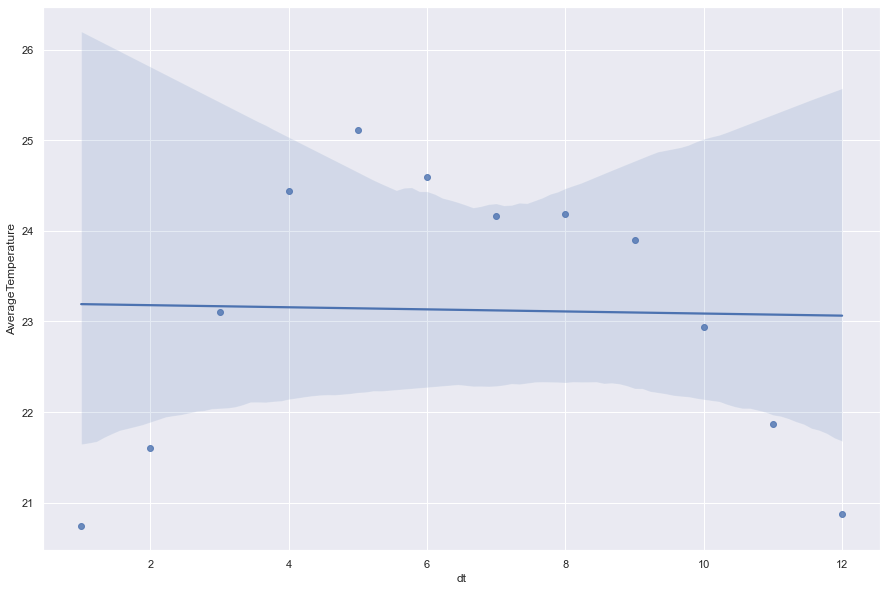

In [39]:
df['dt'] = pd.to_datetime(df['dt'])
monthlyDF = df.groupby(df['dt'].dt.strftime('%m'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature')
# monthlyDF
monthlyDF = monthlyDF.sort_values('dt')
monthlyDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
monthlyDF['AverageTemperature'] = monthlyDF['AverageTemperature'].apply(lambda x: float(x))
monthlyDF['dt'] = monthlyDF['dt'].apply(lambda x: float(x))
sns.regplot(x=monthlyDF["dt"], y=monthlyDF["AverageTemperature"])
plt.show()

#### Comportamiento de la temperatura promedio en los últimos 20 años

Obteniendo temperatura de los últimos años (desde 1900)

In [40]:
lastYearsDF = df[(df['dt'] > '1900-01-01')]
lastYearsDF = (lastYearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
lastYearsDF = lastYearsDF.sort_values('dt')
lastYearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
lastYearsDF['AverageTemperature'] = lastYearsDF['AverageTemperature'].apply(lambda x: float(x))
lastYearsDF['dt'] = lastYearsDF['dt'].apply(lambda x: float(x))
lastYearsDF['type'] = 'lastYears'
lastYearsDF.head()

,dt,AverageTemperature,type
29,1900.0,23.126182,lastYears
2,1901.0,22.326667,lastYears
11,1902.0,22.867417,lastYears
5,1903.0,22.640000,lastYears
1,1904.0,22.309333,lastYears


Obteniendo temperatura de los últimos años (desde 1995)

In [41]:
last20YearsDF = df[(df['dt'] > '1995-09-01') & (df['dt'] < '2013-09-01')]
last20YearsDF = (last20YearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
last20YearsDF = last20YearsDF.sort_values('dt')
last20YearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
last20YearsDF['AverageTemperature'] = last20YearsDF['AverageTemperature'].apply(lambda x: float(x))
last20YearsDF['dt'] = last20YearsDF['dt'].apply(lambda x: float(x))
last20YearsDF['type'] = 'last20Years'
last20YearsDF.head()

,dt,AverageTemperature,type
0,1995.0,22.767333,last20Years
3,1996.0,23.450083,last20Years
16,1997.0,24.076833,last20Years
18,1998.0,24.306500,last20Years
1,1999.0,23.418417,last20Years


Juntando ambos subdatasets

In [42]:
lastYearsDF = pd.concat([lastYearsDF, last20YearsDF], ignore_index=True)
lastYearsDF.head()

,dt,AverageTemperature,type
0,1900.0,23.126182,lastYears
1,1901.0,22.326667,lastYears
2,1902.0,22.867417,lastYears
3,1903.0,22.640000,lastYears
4,1904.0,22.309333,lastYears


Graficando subdatasets

<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

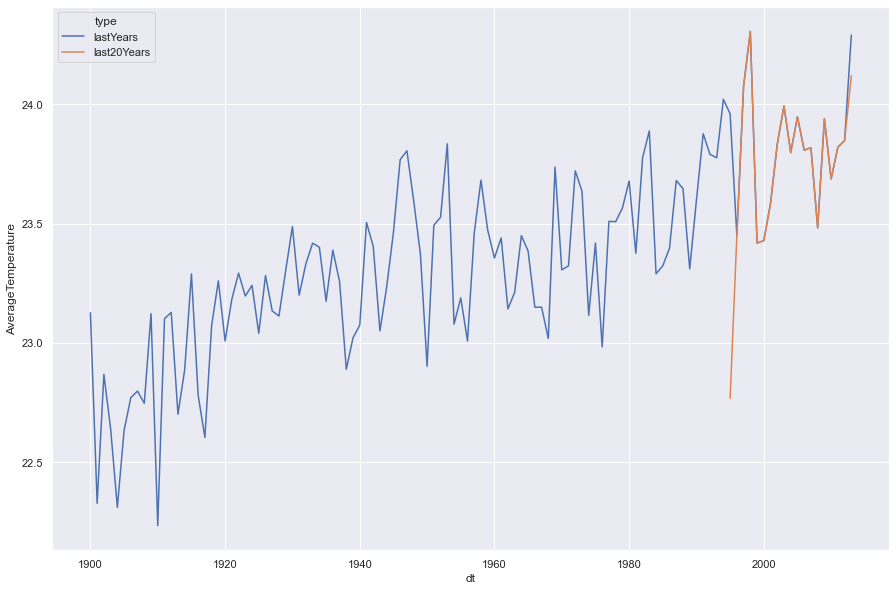

In [43]:
sns.lineplot(x=lastYearsDF["dt"], y=lastYearsDF["AverageTemperature"], hue=lastYearsDF["type"], markers=True)

Graficando solo subdataset de temperatura promedio en los últimos 20 años

<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

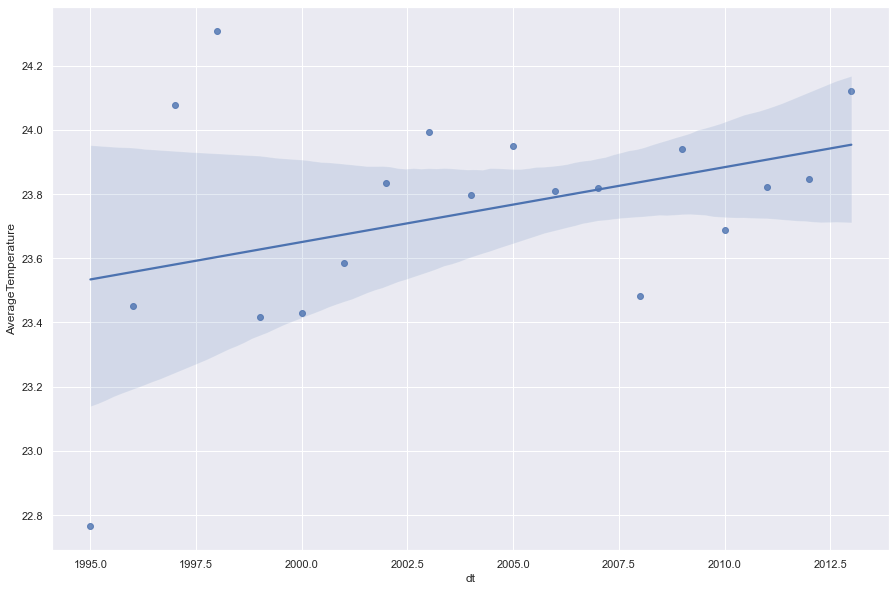

In [44]:
sns.regplot(x=last20YearsDF["dt"], y=last20YearsDF["AverageTemperature"], label='last20Years')

Histograma de la temperatura promedio (Vista en el reporte)

<AxesSubplot:>

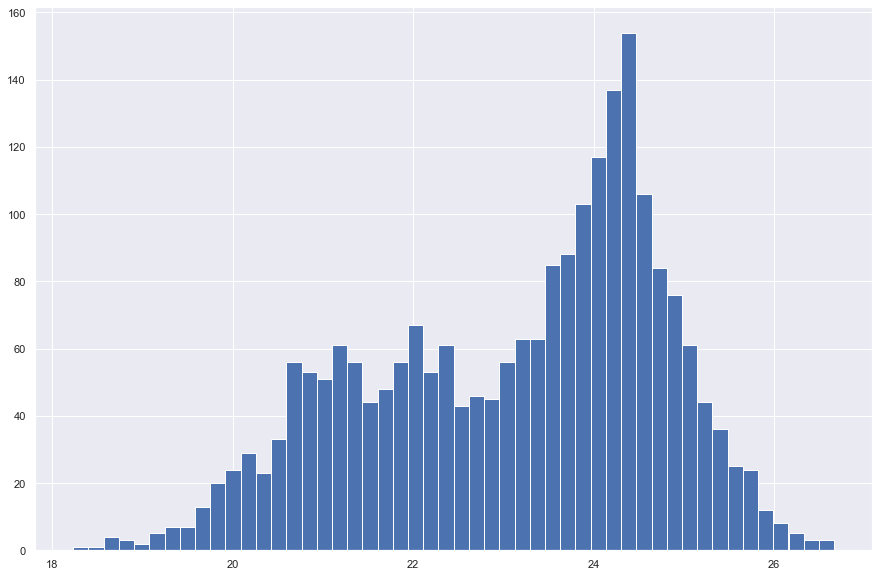

In [45]:
#2a.

df['AverageTemperature'].hist(bins=50)

Descomposición de la serie en sus componentes (Tendencia, estacional y aleatoria)

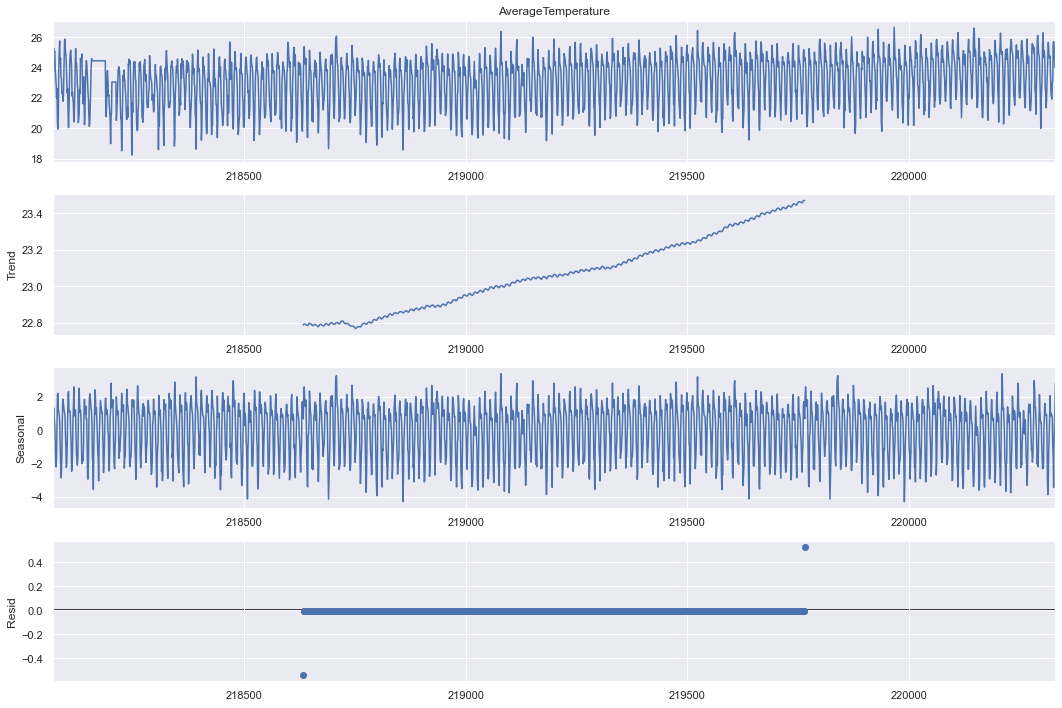

In [46]:
#2c

rcParams['figure.figsize'] = 15, 10

decomposition = sm.tsa.seasonal_decompose(df['AverageTemperature'],model='additive', period=int(2265/2))

fig = decomposition.plot()
plt.show()

Transformación de la serie

In [47]:
#2d 

# No es neecsario por la calidad de los datos

Modelo SARIMA

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

df_selected = pd.read_csv('GlobalLandTemperaturesByCountry.csv', parse_dates = ["dt"], index_col=0)
df_selected = df_selected.dropna()
df_selected = df_selected.loc['2000-01-01':]
df_selected = df_selected.groupby(['dt']).mean()

df_selected = df_selected.drop(['AverageTemperatureUncertainty'], axis=1)
df_selected

p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2]

for p_ in p:
    for d_ in d:
        for q_ in q:
            train = df_selected.iloc[:len(df_selected)-12]
            test = df_selected.iloc[len(df_selected)-12:]

            model = SARIMAX(train['AverageTemperature'], 
                            order = (p_, d_, q_),
                            seasonal_order =(2, 1, 1, 12))

            result = model.fit()
            print(result.summary())
            print('\n')


c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                 SARIMAX Results                                  
Dep. Variable:         AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, [1], 12)   Log Likelihood                 -24.569
Date:                    Sun, 07 Aug 2022   AIC                             57.138
Time:                            21:36:07   BIC                             68.933
Sample:                        01-01-2000   HQIC                            61.931
                             - 09-01-2012                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2542      0.162     -1.565      0.118      -0.573       0.064
ar.S.L24      -0.1970      0.119     -1.655      0.098      -0.430       0.036
ma.S.L12      -0.777

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 -20.664
Date:                            Sun, 07 Aug 2022   AIC                             51.328
Time:                                    21:36:08   BIC                             66.071
Sample:                                01-01-2000   HQIC                            57.319
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2219      0.089      2.480      0.013       0.047       0.397
ar.S.L12      -0.1691      0.165   

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 -19.498
Date:                              Sun, 07 Aug 2022   AIC                             50.996
Time:                                      21:36:09   BIC                             68.688
Sample:                                  01-01-2000   HQIC                            58.185
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2188      0.097      2.263      0.024       0.029       0.408
ma.L2          0.12

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -49.581
Date:                              Sun, 07 Aug 2022   AIC                            107.161
Time:                                      21:36:10   BIC                            118.928
Sample:                                  01-01-2000   HQIC                           111.943
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0478      0.173     -0.276      0.783      -0.387       0.292
ar.S.L24       0.05

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -24.453
Date:                            Sun, 07 Aug 2022   AIC                             58.906
Time:                                    21:36:10   BIC                             73.615
Sample:                                01-01-2000   HQIC                            64.883
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7099      0.073     -9.717      0.000      -0.853      -0.567
ar.S.L12      -0.1341      0.195   

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 -24.023
Date:                              Sun, 07 Aug 2022   AIC                             60.046
Time:                                      21:36:12   BIC                             77.696
Sample:                                  01-01-2000   HQIC                            67.218
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6926      0.096     -7.187      0.000      -0.881      -0.504
ma.L2         -0.11

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 -19.421
Date:                              Sun, 07 Aug 2022   AIC                             48.842
Time:                                      21:36:13   BIC                             63.585
Sample:                                  01-01-2000   HQIC                            54.833
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2827      0.090      3.151      0.002       0.107       0.458
ar.S.L12      -0.13

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 -17.386
Date:                            Sun, 07 Aug 2022   AIC                             46.772
Time:                                    21:36:14   BIC                             64.465
Sample:                                01-01-2000   HQIC                            53.962
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7111      0.213      3.333      0.001       0.293       1.129
ma.L1         -0.4627      0.265   

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 -17.224
Date:                              Sun, 07 Aug 2022   AIC                             48.448
Time:                                      21:36:16   BIC                             69.090
Sample:                                  01-01-2000   HQIC                            56.836
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6702      0.252      2.656      0.008       0.176       1.165
ma.L1         -0.44

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -34.033
Date:                              Sun, 07 Aug 2022   AIC                             78.065
Time:                                      21:36:17   BIC                             92.774
Sample:                                  01-01-2000   HQIC                            84.042
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4457      0.067     -6.628      0.000      -0.578      -0.314
ar.S.L12      -0.06

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -23.023
Date:                            Sun, 07 Aug 2022   AIC                             58.045
Time:                                    21:36:19   BIC                             75.695
Sample:                                01-01-2000   HQIC                            65.217
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2896      0.119      2.441      0.015       0.057       0.522
ma.L1         -0.9946      0.338   

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization 

                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 -23.615
Date:                              Sun, 07 Aug 2022   AIC                             61.231
Time:                                      21:36:21   BIC                             81.822
Sample:                                  01-01-2000   HQIC                            69.599
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4973      0.612      0.813      0.416      -0.701       1.696
ma.L1         -1.14

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 -17.932
Date:                              Sun, 07 Aug 2022   AIC                             47.864
Time:                                      21:36:22   BIC                             65.557
Sample:                                  01-01-2000   HQIC                            55.054
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2464      0.090      2.724      0.006       0.069       0.424
ar.L2          0.14

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 -17.320
Date:                            Sun, 07 Aug 2022   AIC                             48.640
Time:                                    21:36:24   BIC                             69.282
Sample:                                01-01-2000   HQIC                            57.028
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5642      0.487      1.159      0.246      -0.390       1.518
ar.L2          0.0637      0.177   

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 -16.414
Date:                              Sun, 07 Aug 2022   AIC                             48.829
Time:                                      21:36:26   BIC                             72.419
Sample:                                  01-01-2000   HQIC                            58.415
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5051      0.313      4.806      0.000       0.891       2.119
ar.L2         -0.72

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -27.153
Date:                              Sun, 07 Aug 2022   AIC                             66.306
Time:                                      21:36:27   BIC                             83.956
Sample:                                  01-01-2000   HQIC                            73.479
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5864      0.085     -6.929      0.000      -0.752      -0.421
ar.L2         -0.30

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -21.444
Date:                            Sun, 07 Aug 2022   AIC                             56.888
Time:                                    21:36:29   BIC                             77.479
Sample:                                01-01-2000   HQIC                            65.256
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2521      0.119      2.114      0.034       0.018       0.486
ar.L2          0.1519      0.099   

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 -22.869
Date:                              Sun, 07 Aug 2022   AIC                             61.738
Time:                                      21:36:31   BIC                             85.271
Sample:                                  01-01-2000   HQIC                            71.301
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6803      0.234     -2.908      0.004      -1.139      -0.222
ar.L2          0.26

Modelo Prophet

In [49]:
from prophet import Prophet

Comprobaciones para el modelo Prophet

In [50]:
df_selected = df[["dt", "AverageTemperature"]]

# comprobando que la columna de tiempo este en formato datetime
print(df_selected.dtypes)

# Comprobando que las columnas se llamen "ds" y "y" respectivamente
df_selected.rename(columns={'dt': 'ds', 'AverageTemperature': 'y'}, inplace=True)
print(df_selected.head())

dt                    datetime64[ns]
AverageTemperature           float64
dtype: object
               ds       y
218067 1825-01-01  21.204
218068 1825-02-01  21.584
218069 1825-03-01  23.038
218070 1825-04-01  25.276
218071 1825-05-01  24.995


Creando modelo de la clase Prophet

In [51]:
# 95% de intervalo de incertidumbre
m = Prophet(interval_width = 0.95)


In [52]:
df_selected = df_selected.loc[df_selected['ds'] < '2010-09-01']
m.fit(df_selected)

21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing


Creando nuevas fechas para las predicciones

In [53]:
prediction_dates = m.make_future_dataframe(periods=36, freq='MS')
prediction_dates.tail()

,ds
2259,2013-04-01
2260,2013-05-01
2261,2013-06-01
2262,2013-07-01
2263,2013-08-01


Obteniendo columnas de la prediccion

In [54]:
predict = m.predict(prediction_dates)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2259,2013-04-01,25.239723,24.018607,26.404056
2260,2013-05-01,25.953599,24.729804,27.143937
2261,2013-06-01,25.344258,24.119039,26.585602
2262,2013-07-01,24.910753,23.811195,26.173693
2263,2013-08-01,24.992565,23.773919,26.220572


Graficando predicciones

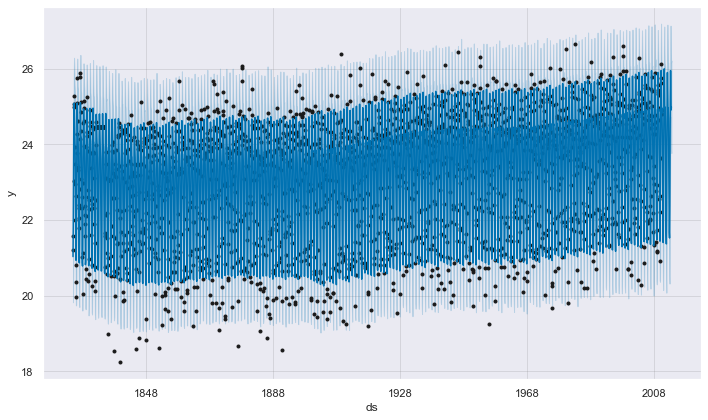

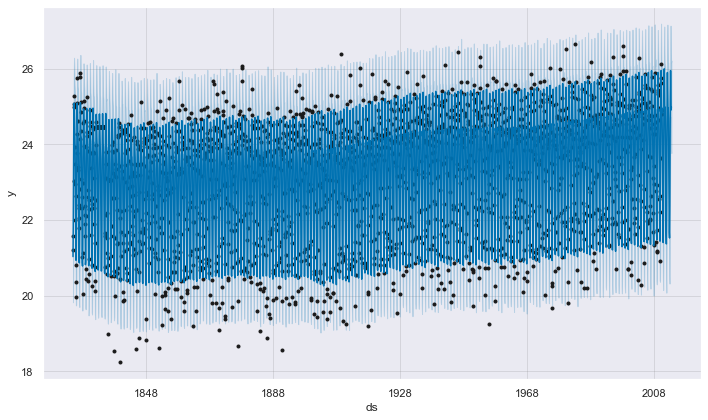

In [55]:
m.plot(predict, uncertainty=True)

Graficando componentes

Graficando subdataset de las predicciones

,ds,y,type
0,1900-02-01,21.273968,yhat
1,1900-03-01,22.756409,yhat
2,1900-04-01,24.085324,yhat
3,1900-05-01,24.770364,yhat
4,1900-06-01,24.237618,yhat


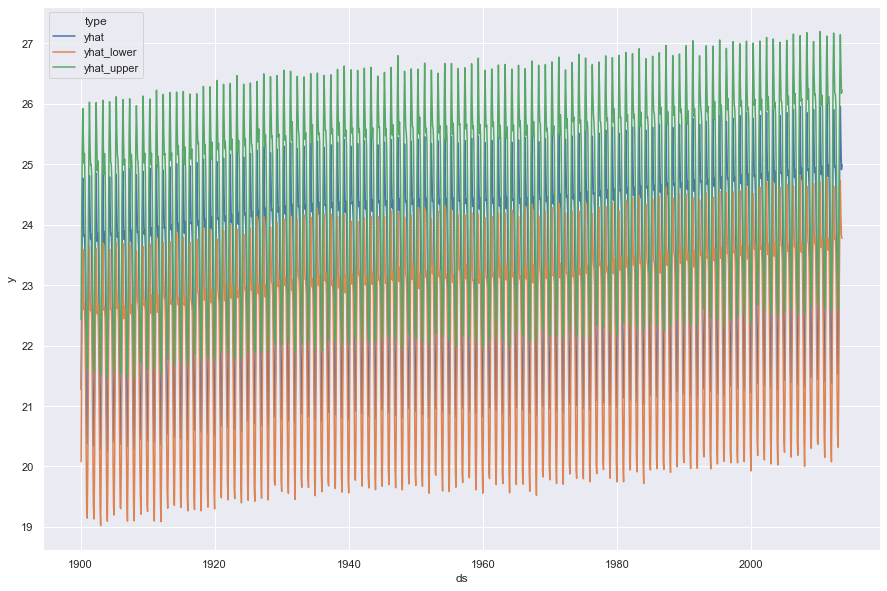

In [56]:
# seleccionar por un rango de fechas
pd.options.mode.chained_assignment = None  # default='warn'
df_selected = predict.loc[predict['ds'] > '1900-01-01']
# join all columns into one with different types in a new column called 'type'
df_selected_yh = df_selected[['ds', 'yhat']]
df_selected_yh.columns = ['ds', 'y']
df_selected_yh['type'] = 'yhat'
df_selected_yhl = df_selected[['ds', 'yhat_lower']]
df_selected_yhl.columns = ['ds', 'y']
df_selected_yhl['type'] = 'yhat_lower'
df_selected_yhu = df_selected[['ds', 'yhat_upper']]
df_selected_yhu.columns = ['ds', 'y']
df_selected_yhu['type'] = 'yhat_upper'
df_selected = pd.concat([df_selected_yh, df_selected_yhl, df_selected_yhu], ignore_index=True)
# graficar el modelo
sns.lineplot(x='ds', y='y', data=df_selected, hue='type', markers=True)
df_selected.head()

Validacion del modelo

MAPE: 0.017624873427548846


<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

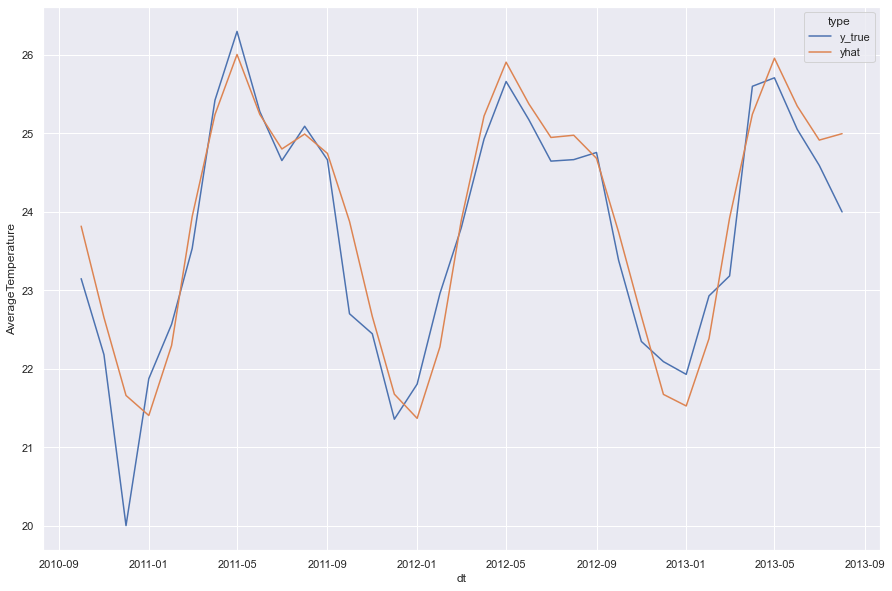

In [57]:
from sklearn.metrics import mean_absolute_percentage_error

y_true = df.loc[df['dt'] > '2010-09-01']
# select columns
y_true = y_true[['dt', 'AverageTemperature']]
# get an avergafe of the AverageTemperature of each same datetime in column dt
y_true = y_true.groupby(['dt']).mean().reset_index()
y_true['type'] = 'y_true'
# select only 35 first rows
y_true = y_true.iloc[:35]

# get only yhat from the prediction
y_pred = df_selected.loc[df_selected['ds'] > '2010-09-01']
y_pred = y_pred[y_pred['type'] == 'yhat']

# rename columns
y_pred.rename(columns={'ds': 'dt', 'y': 'AverageTemperature'}, inplace=True)
mape = mean_absolute_percentage_error(y_true['AverageTemperature'], y_pred['AverageTemperature'])
print(f'MAPE: {mape}')

y_true = pd.concat([y_true, y_pred], ignore_index=True)
sns.lineplot(x='dt', y='AverageTemperature', data=y_true, hue='type', markers=True)


Prophet predict of future 3 years

21:36:34 - cmdstanpy - INFO - Chain [1] start processing
21:36:35 - cmdstanpy - INFO - Chain [1] done processing


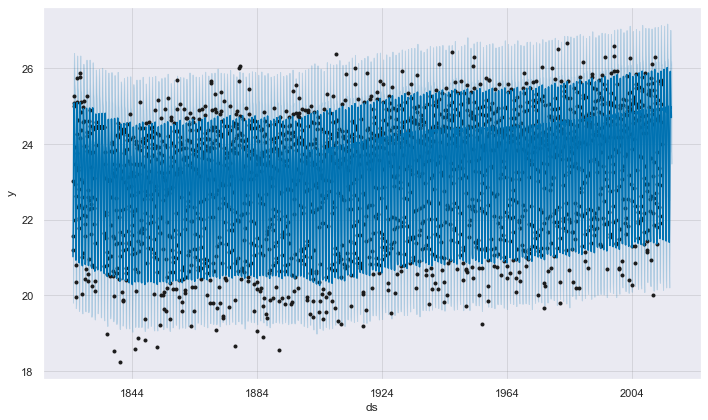

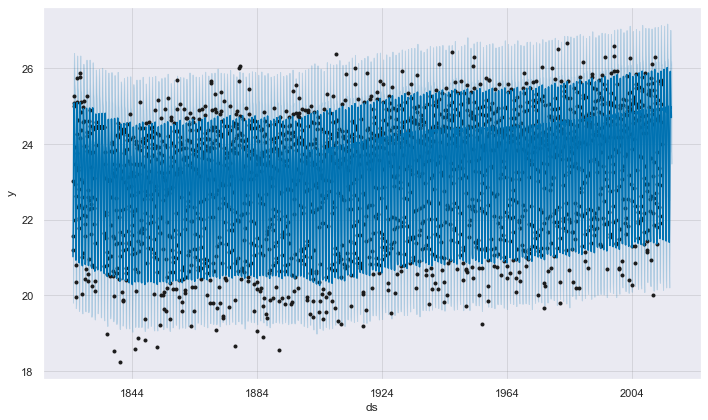

In [58]:
# 95% de intervalo de incertidumbre
m = Prophet(interval_width = 0.95)
# seleccionando columnas
df_selected = df[["dt", "AverageTemperature"]]
# Comprobando que las columnas se llamen "ds" y "y" respectivamente
df_selected.rename(columns={'dt': 'ds', 'AverageTemperature': 'y'}, inplace=True)
# fit with all data
m.fit(df_selected)
# make future dataframe
prediction_dates = m.make_future_dataframe(periods=36, freq='MS')
prediction_dates.tail()
# predict and get columns
predict = m.predict(prediction_dates)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# plot the model
m.plot(predict, uncertainty=True)

,ds,y,type
0,2010-02-01,22.301731,yhat
1,2010-03-01,23.866468,yhat
2,2010-04-01,25.191040,yhat
3,2010-05-01,25.929195,yhat
4,2010-06-01,25.240655,yhat


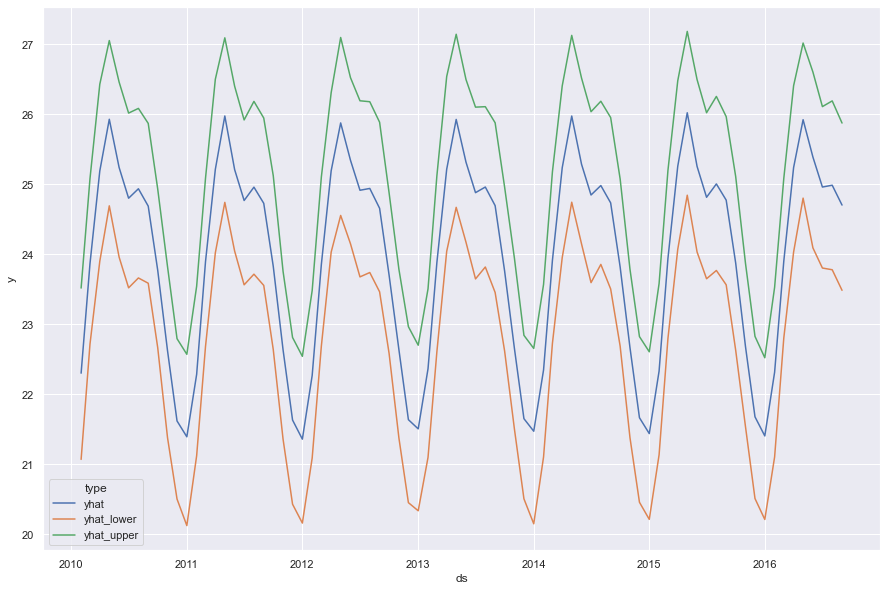

In [59]:
# seleccionar por un rango de fechas
pd.options.mode.chained_assignment = None  # default='warn'
df_selected = predict.loc[predict['ds'] > '2010-01-01']
# join all columns into one with different types in a new column called 'type'
df_selected_yh = df_selected[['ds', 'yhat']]
df_selected_yh.columns = ['ds', 'y']
df_selected_yh['type'] = 'yhat'
df_selected_yhl = df_selected[['ds', 'yhat_lower']]
df_selected_yhl.columns = ['ds', 'y']
df_selected_yhl['type'] = 'yhat_lower'
df_selected_yhu = df_selected[['ds', 'yhat_upper']]
df_selected_yhu.columns = ['ds', 'y']
df_selected_yhu['type'] = 'yhat_upper'
df_selected = pd.concat([df_selected_yh, df_selected_yhl, df_selected_yhu], ignore_index=True)
# graficar el modelo
sns.lineplot(x='ds', y='y', data=df_selected, hue='type', markers=True)
df_selected.head()